In [1]:
import os
import sys
sys.path.append("../data/neural_data/")
sys.path.append("../utils/")
sys.path.append("../fig1_1d2map/")
from pathlib import Path

import numpy as np
import itertools
import matplotlib.pyplot as plt

import basic_analysis as basic
import fig6_analysis as analysis
import analysis_neuro as spk
import fig6_plots
import supp_fig3_plots as supp_plots

In [2]:
# file paths
data_folder = f"../data/neural_data/"
save_folder = f"../figures/supp_multimap_neural_plots/"
if os.path.isdir(save_folder):
    print('save folder exists')
else:
    os.mkdir(save_folder)
    
title_size = 10

save folder exists


In [3]:
# define the mouse, session, and example cell IDs
mice = ['Seattle', 'Toronto', 'Seattle', 'Toronto']
sessions = ['1010_1', '1111_1', '1006_1', '1117_1']
ex_cells = np.asarray([529, 521, 274, 252])
session_maps = np.asarray([3, 3, 4, 4])

session_IDs = []
for m, s in zip(mice, sessions):
    session_IDs.append(f'{m}_{s}')

In [4]:
''' load the data '''
THRESH = 0.25
data = {}
for i, session_ID in enumerate(session_IDs):
    n_maps = session_maps[i]
    d = analysis.load_neural_data(data_folder, session_ID)
    print(f'loaded data for {session_ID}')

    # filter by stability, run kmeans, get network similarity
    d = analysis.format_neural_data(d, n_maps=n_maps,
                                    filter_stability=True, 
                                    unstable_thresh=THRESH)
    data[session_ID] = d
    n_trials = d['kmeans']['W'].shape[0]
    print(f'formatted data for {session_ID}, N trials = {n_trials}')

loaded data for Seattle_1010_1
formatted data for Seattle_1010_1, N trials = 260
loaded data for Toronto_1111_1
formatted data for Toronto_1111_1, N trials = 240
loaded data for Seattle_1006_1
formatted data for Seattle_1006_1, N trials = 390
loaded data for Toronto_1117_1
formatted data for Toronto_1117_1, N trials = 397


In [5]:
''' compute firing rates for each map '''
dt = 0.02 # time bin
pos_bin = 2 # cm
for i, session_ID in enumerate(session_IDs):
    d = data[session_ID]
    A = d['A'] # behavior
    B = d['B'] # spikes
    
    n_maps = session_maps[i]
    n_pos_bins = 400 // pos_bin
    n_cells = B.shape[-1]

    FRs = np.zeros([n_maps, n_pos_bins, n_cells])
    FRs_sem = np.zeros([n_maps, n_pos_bins, n_cells])
    for j in range(n_maps):
        m_idx = d['idx'][j, :]
        FRs[j], binned_pos, FRs_sem[j] = spk.tuning_curve(A[m_idx, 0],
                                                          B[m_idx, :],
                                                          dt, b=2, SEM=True)
    d['FR'] = FRs
    d['FR_sem'] = FRs_sem

In [6]:
''' save remap index for plotting '''
for i, session_ID in enumerate(session_IDs):
    d = data[session_ID]
    W = d['kmeans']['W']
    
    n_maps = session_maps[i]
    trials = np.arange(0, W.shape[0]-1)

    # define remaps
    remap_idx = np.asarray([])
    for j in range(n_maps):
        remaps = np.where(np.abs(np.diff(W[:, j])))[0]
        remap_idx = np.append(remap_idx, remaps)
    remap_idx = np.unique(remap_idx)
    remap_idx = remap_idx.astype(int)
    d['remap_idx'] = remap_idx

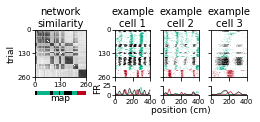

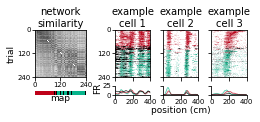

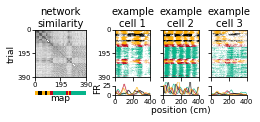

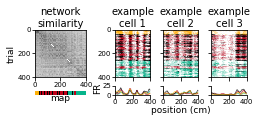

In [7]:
''' Network-wide trial-trial similarity and single cell examples '''
ex_cells = np.asarray([
    [529, 528, 95], # Seattle_1010_1
    [521, 519, 402], # Toronto_1111_1
    [341, 313, 249], # Seattle_1006_1
    [252, 250, 163] # Toronto_1117_1
])

for i, session_ID in enumerate(session_IDs):
    #data params
    d = data[session_ID]
    FRs = d['FR']
    FRs_sem = d['FR_sem']
    c_id = ex_cells[i]
    
    # make figure
    f, gs = supp_plots.plot_a(d=d, cell_ID=c_id,
                              all_FR=FRs,
                              all_FR_sem=FRs_sem,
                              binned_pos=binned_pos)
    f.savefig(f'{save_folder}{session_ID}_examples.png',
              dpi=600, bbox_inches='tight')
    plt.show()

In [11]:
''' define the map pairs '''
for i, session_ID in enumerate(session_IDs):
    d = data[session_ID]
    n_maps = session_maps[i]

    m_ids = np.arange(n_maps)
    m_pairs = list(itertools.combinations(m_ids,2))
    for j, p in enumerate(m_pairs):
        m_pairs[j] = np.asarray(p)
    d['map_pairs'] = m_pairs

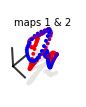

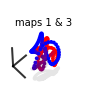

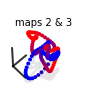

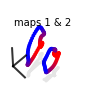

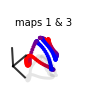

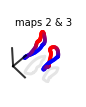

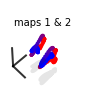

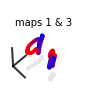

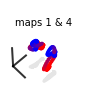

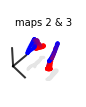

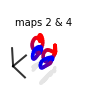

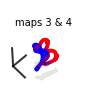

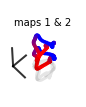

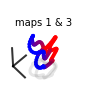

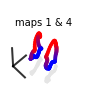

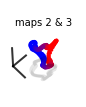

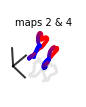

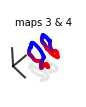

In [12]:
''' Figure 6B: example aligned manifolds for all pairs '''
for i, session_ID in enumerate(session_IDs):
    d = data[session_ID]
    
    # get the centers for each position bin
    pos = d['A'][:, 0]
    bin_size = 5
    edges = np.arange(0, np.max(pos) + bin_size, bin_size)
    binned_pos = (edges[:-1] + edges[1:])/2

    # data params
    Y = d['Y'].copy()
    map_idx = d['idx']
    W = d['kmeans']['W'].copy()
    W_bool = W.astype(bool)

    # plots
    m_pairs = d['map_pairs']
    for m0_id, m1_id in m_pairs:
        map_idx = W_bool[:, m0_id] | W_bool[:, m1_id]
        f, ax = fig6_plots.plot_c(Y[map_idx], binned_pos)
        ax.set_title(f'maps {m0_id+1} & {m1_id+1}',
                     fontsize=title_size, pad=-2)
        plt.show()
        f.savefig(f'{save_folder}{session_ID}_manifolds_{m0_id+1}{m1_id+1}.png', 
                  dpi=600, bbox_inches='tight')

overall mean misalignment = 0.7
overall sem misalignment = 0.056
Seattle_1010_1 mean misalignment = 1.0
Toronto_1111_1 mean misalignment = 0.55
Seattle_1006_1 mean misalignment = 0.78
Toronto_1117_1 mean misalignment = 0.51


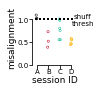

In [4]:
f, ax = fig6_plots.plot_d(data_folder, session_IDs, session_maps)
plt.show()